# Lesson

## Import

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Code

In [ ]:
def compute_model(y_name, X_name, data):
    y = data.loc[:, y_name]
    X = sm.add_constant(data.loc[:, X_name].values)
    model = sm.OLS(y, X).fit()
    return show_table(model, X_name)

In [ ]:
def show_table(model, X_name):
    index_name = ['Intercept']

    if isinstance(X_name, str):
        index_name.append(X_name)
    elif isinstance(X_name, list):
        index_name = index_name + X_name

    df = pd.read_html(model.summary2().as_html())[1]
    colname = df.iloc[0]
    df = df.rename(columns=df.iloc[0]).drop(0).set_index(np.nan)
    df.index.name = None
    df.index = index_name

    return df

In [ ]:
def compute_VIF(columns, data):
    X = data.loc[:, columns]
    X.loc[:, 'Intercept'] = 1
      
    vif = pd.DataFrame()
    vif.loc[:, 'variables'] = X.columns
    vif.loc[:, 'VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
      
    return vif.drop(vif.tail(1).index)

In [ ]:
advertising = pd.read_csv('data/Advertising.csv')
credit = pd.read_csv('data/Credit.csv')

In [ ]:
# table 3.2
y = advertising['sales']
X = advertising[['TV']]
X = sm.add_constant(X)
slr = sm.OLS(y, X).fit()
rss = slr.resid.std(ddof=X.shape[1])
print(f'RSS: {rss}')
slr.summary().tables[0]

In [ ]:
# table 3.1
compute_model('sales', 'TV', advertising)

In [ ]:
# table 3.3
compute_model('sales', 'radio', advertising)

In [ ]:
# table 3.3
compute_model('sales', 'newspaper', advertising)

In [ ]:
# table 3.4
y = advertising['sales']
X = advertising[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
mlr = sm.OLS(y, X).fit()
mlr.summary().tables[1]

In [ ]:
# table 3.6
y = advertising['sales']
X = advertising[['TV', 'radio', 'newspaper']]
X = sm.add_constant(X)
mlr = sm.OLS(y, X).fit()
rss = mlr.resid.std(ddof=X.shape[1])
print(f'RSS: {rss}')
mlr.summary().tables[0]

In [ ]:
# table 3.7
credit_owner_dummy = pd.get_dummies(credit, columns=['Own'])
compute_model('Balance', 'Own_Yes', credit_owner_dummy)

In [ ]:
# table 3.8
credit_region_dummy = pd.get_dummies(credit, columns=['Region'])
compute_model('Balance', ['Region_West', 'Region_South'], credit_region_dummy)

In [ ]:
# table 3.9
advertising['TVxradio'] = advertising['TV'] * advertising['radio']
compute_model('sales', ['TV', 'radio', 'TVxradio'], advertising)

In [ ]:
# table 3.11
compute_model('Balance', ['Age', 'Limit'], credit)
compute_model('Balance', ['Rating', 'Limit'], credit)

In [ ]:
compute_VIF(['TV', 'radio', 'newspaper'], advertising)

# Lab

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly

In [2]:
plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300

In [3]:
IMG_EXPORT_CONFIG = {
    'dpi': 500,
    'bbox_inches': 'tight',
    'pad_inches': 0.15,
}

In [4]:
sns.set_theme(style='whitegrid')
sns.set_palette('hls', 8)

## Code

The `boston` dataset records `medv` (median house value) for 506 neighborhoods around Boston. 

We will build a regression model to predict `medv` using **13** predictors such as:
- `rmvar` (average number of rooms per house),
- `age` (proportion of owner-occupied units built prior to 1940), and
- `lstat` (percent of households with low socioeconomic status).

In [5]:
boston_df = load_data('Boston')
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [6]:
boston_df?

Type:        DataFrame
String form:
crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
           0    0.00632  18.0   2.3 <...> 0   5.64  23.9
           504     21.0   6.48  22.0
           505     21.0   7.88  11.9
           
           [506 rows x 13 columns]
Length:      506
File:        /opt/homebrew/lib/python3.10/site-packages/pandas/core/frame.py
Docstring:  
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index.

### Simple Linear Regression

Our response will be `medv` and `lstat` will be the single predictor.

In [7]:
X = pd.DataFrame({
    'intercept': np.ones(boston_df.shape[0]),
    'lstat': boston_df['lstat'],
})
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


`sm.OLS()` does not fit the model, rather it specifies the model, and then `model.fit()` does the actual fitting.

In [8]:
y = boston_df['medv']
slr = sm.OLS(y, X)
slr_result = slr.fit()

In [9]:
summarize(slr_result)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [10]:
slr_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           5.08e-88
Time:                        21:22:35   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
slr_result.params

intercept    34.553841
lstat        -0.950049
dtype: float64

#### Using Transformations: Fit and Transform

`ModelSpec()` (renamed `MS()` in the preamble) creates a transform object, and then a pair of methods `transform()` and `fit()` are used to construct a corresponding model matrix.

In this simple case, the `fit()` method does very little; it simply checks that the variable `lstat` specified in design exists in `boston`. Then `transform()` constructs the model matrix with two columns: an intercept and the variable `lstat`.

These two operations can be combined with the `fit_transform() `method.

In [12]:
design = MS(['lstat'])
# option 1
design = design.fit(boston_df)
X = design.transform(boston_df)
# option 2
X = design.fit_transform(boston_df)
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


The `get_prediction()` method can be used to obtain predictions, and produce confidence intervals and prediction intervals for the prediction of `medv` for given values of `lstat`.

In [13]:
new_df = pd.DataFrame({'lstat': [5, 10, 15]})
new_X = design.transform(new_df)
new_X

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [14]:
new_pred = slr_result.get_prediction(new_X)
new_pred.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [17]:
# confidence interval
new_pred.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [18]:
# prediction internal
new_pred.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

The 95% confidence interval associated with an `lstat` value of 10 is (24.47, 25.63), and the 95% prediction interval is (12.82, 37.28).

#### Defining Functions

In [39]:
def add_linear_line(ax, m, b, *args, **kwargs):
    """ Add a line with slope m and intercept b to ax """
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

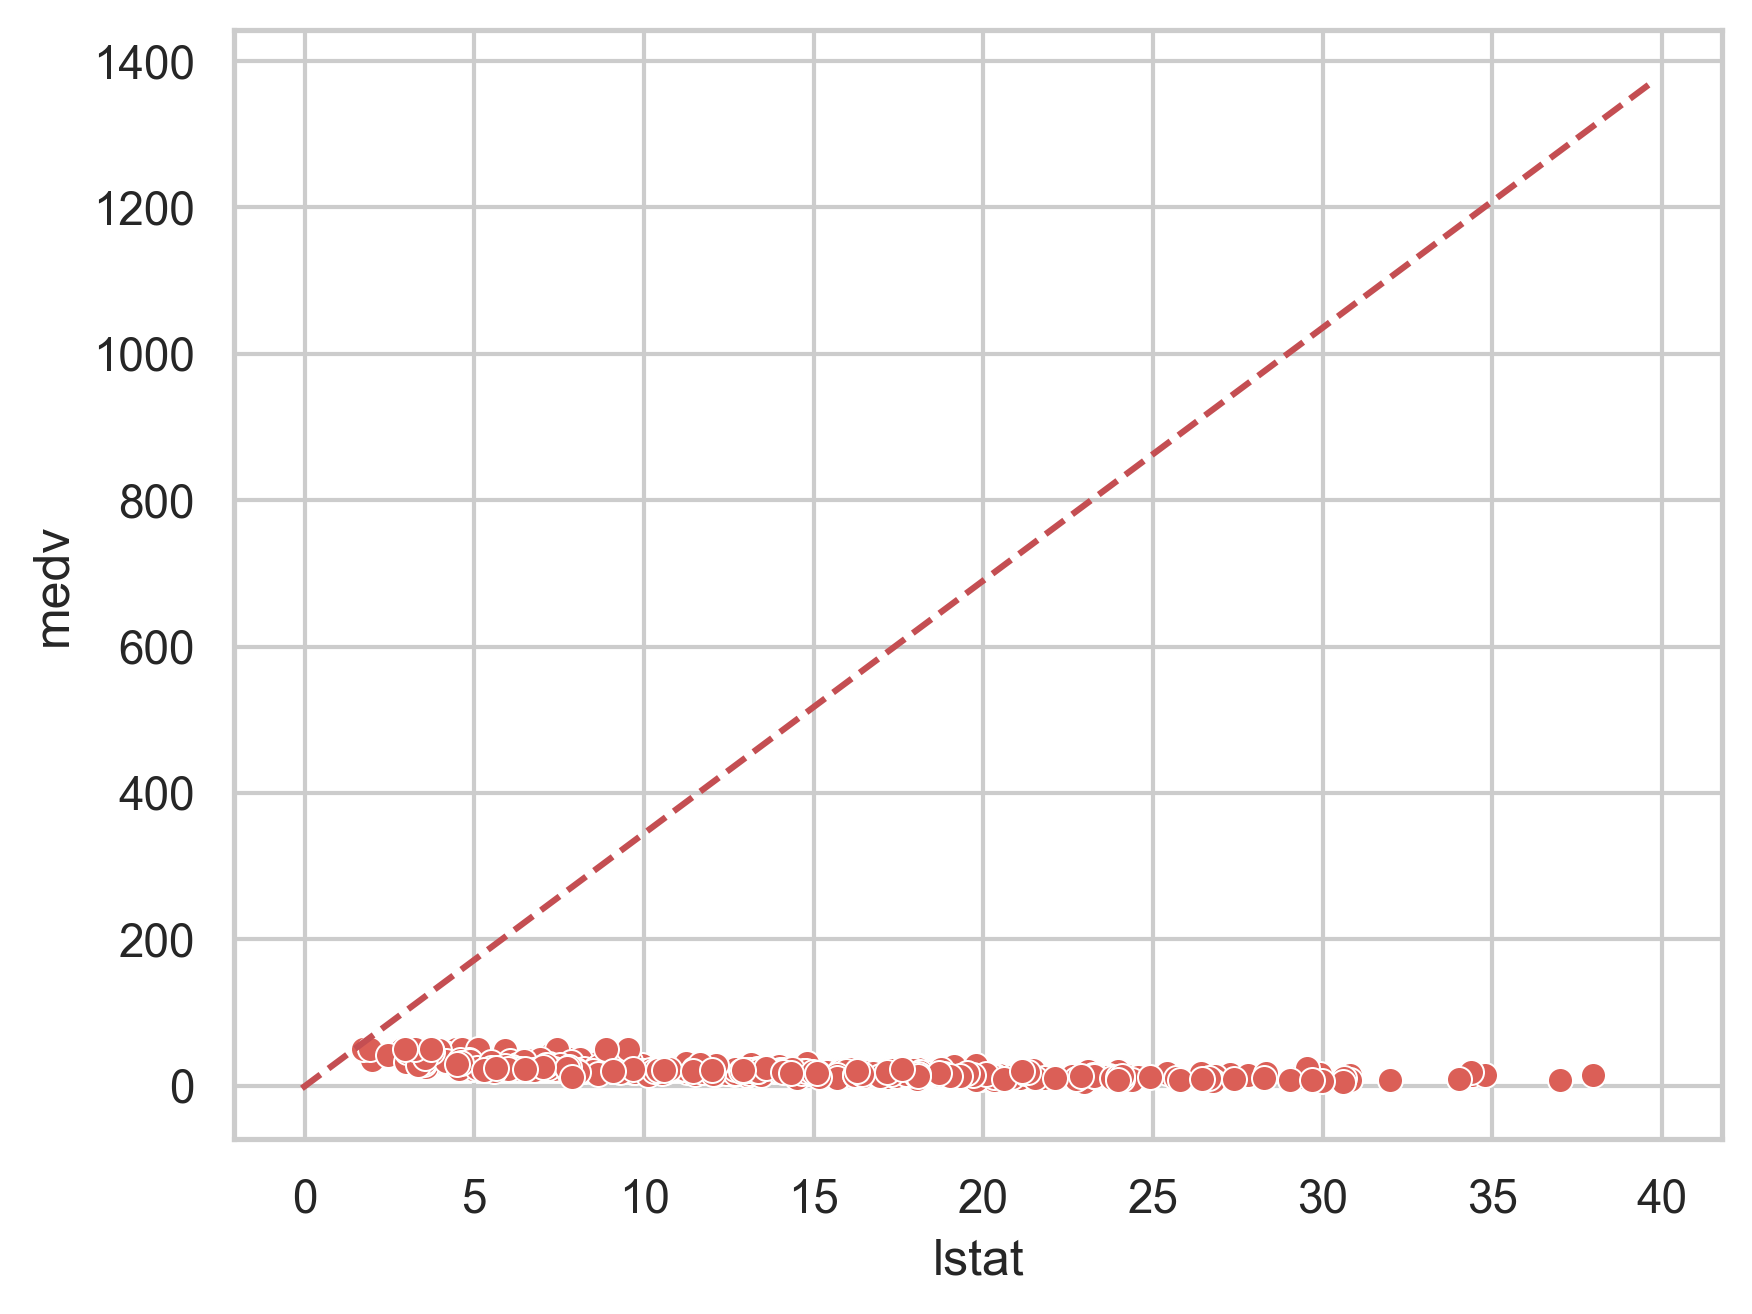

In [40]:
fig, ax = plt.subplots()
sns.scatterplot(x='lstat', y='medv', data=boston_df, ax=ax)
add_linear_line(ax, slr_result.params[0], slr_result.params[1], 'r--')

We plot the fitted values (`.fittedvalues`) against theirs residuals (`.resid`). We add a horizontal line at `0` for reference using the `ax.axhline()` method, indicating it should be black (`c='k'`) and have a dashed linestyle (`ls='--'`).

From the plot, there is some evidence of non-linearity.

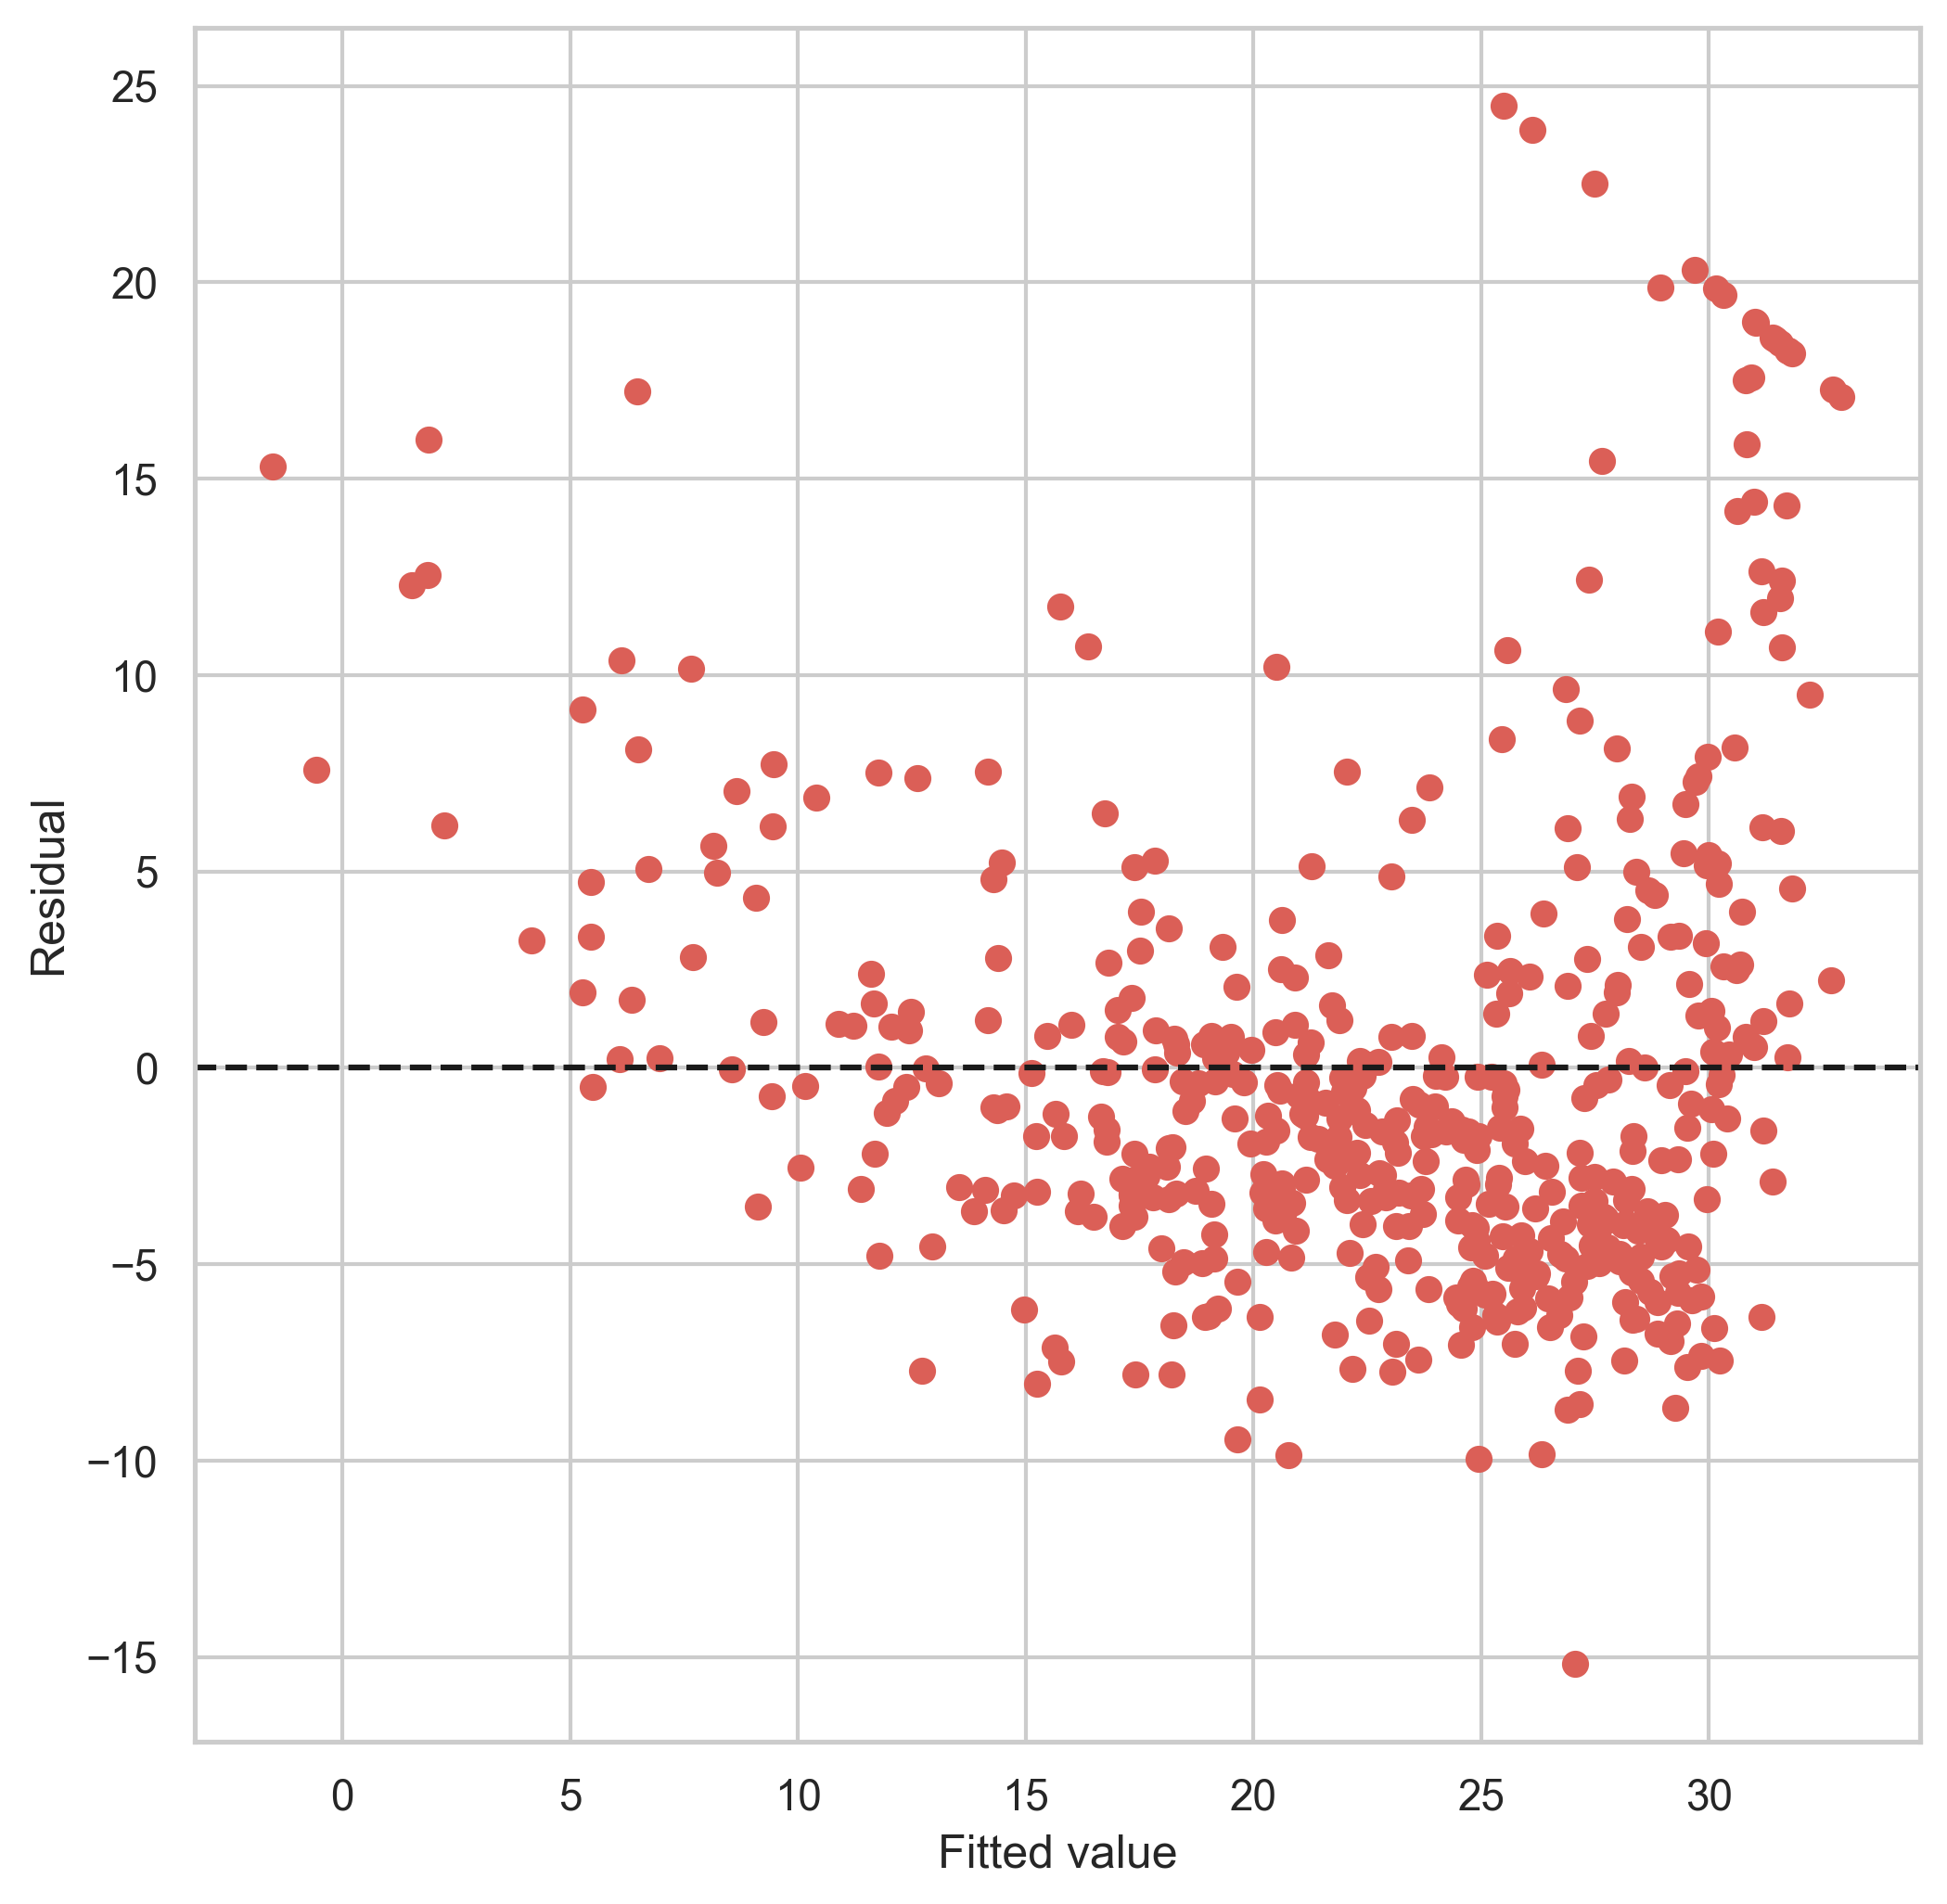

In [37]:
ax = plt.subplots(figsize=(8, 8))[1]
ax.scatter(slr_result.fittedvalues, slr_result.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

Various influence measures describing the regression model are computed with the `get_influence()` method.

Leverage statistics can be computed for any number of predictors using the `hat_matrix_diag` attribute of the value returned by the `get_influence()` method.

The `np.argmax()` function identifies the index of the largest element of an array, optionally computed over an axis of the array.

In [46]:
influence = slr_result.get_influence()
influence.summary_frame()

,dfb_intercept,dfb_lstat,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.059716,0.044977,0.001886,-0.938750,0.004263,-0.061420,-0.938639,-0.061413
1,-0.028156,0.015069,0.000582,-0.687871,0.002456,-0.034128,-0.687511,-0.034110
2,0.044083,-0.034510,0.001004,0.641041,0.004864,0.044815,0.640666,0.044789
3,0.019757,-0.016039,0.000198,0.264480,0.005640,0.019918,0.264236,0.019900
4,0.066762,-0.049471,0.002384,1.081699,0.004059,0.069053,1.081882,0.069065
...,...,...,...,...,...,...,...,...
501,-0.018179,0.008887,0.000266,-0.477868,0.002322,-0.023053,-0.477502,-0.023035
502,-0.035414,0.019126,0.000912,-0.858140,0.002472,-0.042719,-0.857915,-0.042708
503,-0.051219,0.037367,0.001421,-0.853618,0.003886,-0.053317,-0.853387,-0.053303
504,-0.057161,0.039732,0.001843,-1.031025,0.003456,-0.060717,-1.031090,-0.060721


374

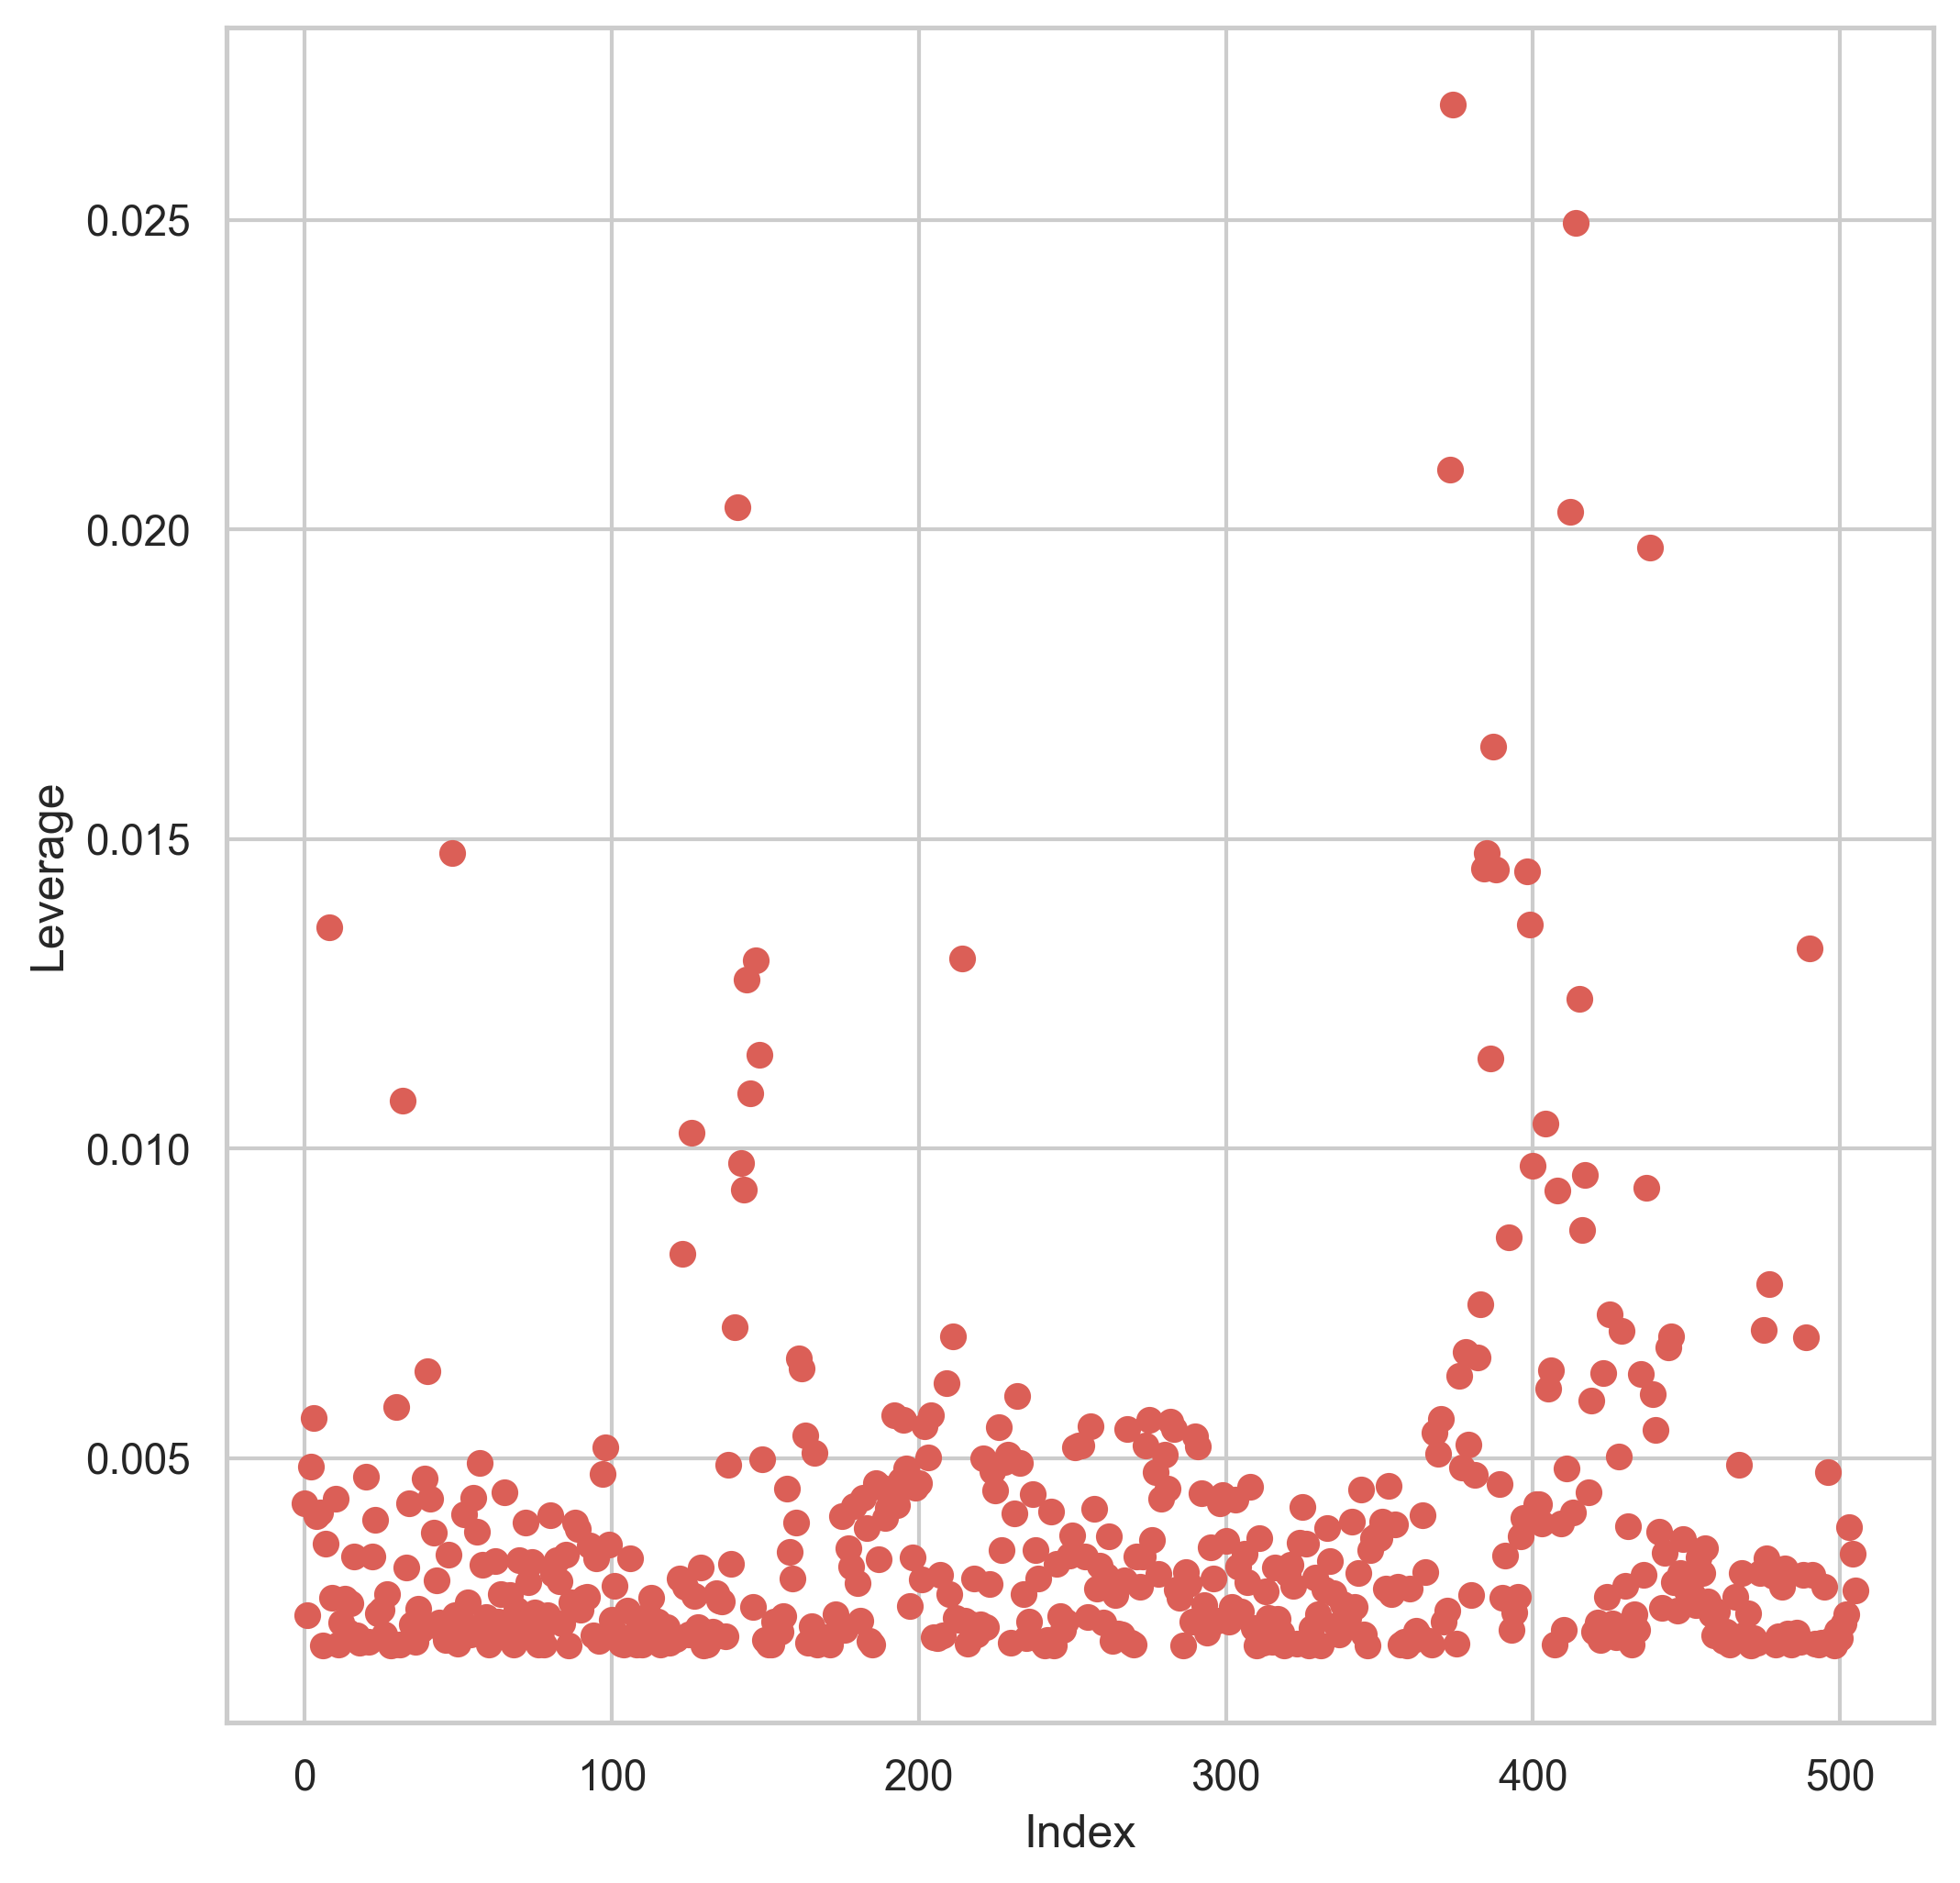

In [43]:
ax = plt.subplots(figsize=(8, 8))[1]
ax.scatter(np.arange(X.shape[0]), influence.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(influence.hat_matrix_diag)

### Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the `ModelSpec()` transform to construct the required model matrix and response.

In [48]:
X = MS(['lstat', 'age']).fit_transform(boston_df)
mlr = sm.OLS(y, X)
mlr_result = mlr.fit()
summarize(mlr_result)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


Now, we will use all columns to predict `medv`.

In [49]:
terms = boston_df.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [50]:
X = MS(terms).fit_transform(boston_df)
mlr = sm.OLS(y, X)
mlr_result = mlr.fit()
summarize(mlr_result)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


From the summarize, we see that `indus` and `age` has high $p$-value. So we'd remove these 2 columns from the prediction.

In [52]:
new_terms = boston_df.columns.drop(['medv', 'indus', 'age'])
new_X = MS(new_terms).fit_transform(boston_df)
new_mlr = sm.OLS(y, new_X)
new_mlr_result = new_mlr.fit()
summarize(new_mlr_result)

,coef,std err,t,P>|t|
intercept,41.4517,4.903,8.454,0.000
crim,-0.1217,0.033,-3.696,0.000
zn,0.0462,0.014,3.378,0.001
chas,2.8719,0.863,3.329,0.001
nox,-18.2624,3.565,-5.122,0.000
rm,3.6730,0.409,8.978,0.000
dis,-1.5160,0.188,-8.078,0.000
rad,0.2839,0.064,4.440,0.000
tax,-0.0123,0.003,-3.608,0.000
ptratio,-0.9310,0.130,-7.138,0.000


### Multivariate Goodness of Fit

#### List Comprehension

**Variance Inflation Factor (VIF):** is the ratio of the variance of $\hat\beta_j$ when fitting the full model divided by the variance of $\hat\beta_j$ if fit on its own.

Function `VIF()` takes 2 arguments: a dataframe or array, and a variable column index.

In [56]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vals}, index=X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


### Interaction Terms

**Interaction Term:** constructed by computing the product of $X_1$ and $X_2$.

⟹ Extended model: $$Y = \beta_0 + \beta_1X1 + \beta_2X_2 + \beta_3X_1X_2 + \epsilon$$

Including a tuple `('lstat', 'age')` tells the model matrix builder to include an interaction term between `lstat` and `age`.

In [57]:
X_2 = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(boston_df)
mlr_2 = sm.OLS(y, X_2)
mlr_result_2 = mlr_2.fit()
summarize(mlr_result_2)

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025
